# Siemens Star Analysis
## In this notebook I wil show how to use the Siemens Star Target to characterize the Modulation Transfer Function of an optical system.

In [6]:
import numpy as np
import pyfits
import matplotlib.pyplot as plt
import skimage
from skimage.feature import blob_dog, blob_doh, blob_log, canny
from skimage.color import rgb2gray
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.segmentation import slic
from skimage.filters import sobel
from scipy.signal import convolve2d

from scipy.ndimage import gaussian_filter
from skimage import measure
from scipy.optimize import curve_fit
import matplotlib.ticker as mtick
from scipy.signal import savgol_filter


In [7]:
path = '/home/fatima/Desktop/solar_orbiter_project/codes/targets/MTF/'

In [15]:
star = pyfits.getdata(path+'solo_L0_1805230011_20180523T121104.fits')
dark = pyfits.getdata(path+'solo_L0_1805230009_20180523T094103.fits')
data = star/20. -dark/20.

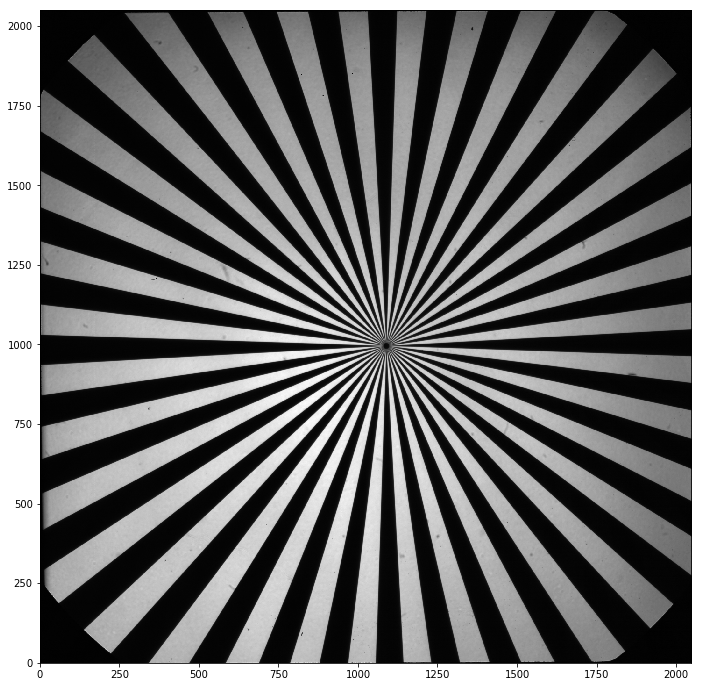

In [16]:
fig = plt.figure(figsize=(18,12))

plt.imshow(data,origin='lower',cmap='gray')

### The siemens star target is used in the characterization of the performance of an optical system (from microscopes to telescopes). It consists of alternating black and white stripes who are densely packed near the center of the image and sparsing out towards the edges. 

### The modulation transfer function inspects the contrast variation with spatial frequency. You could get the latter from applying Fourier transform, but in targets like the Siemens star you could measure both the contrast and the spatial frequency. As you could see, the spatial frequency in the siemens star increases from the edges towards the center. Think of the spatial frequency as the inverse of the period which is the distance from white to white or black to black, since this distance increases towards the edges, the spatial frequency decreases. You could also notice how the contrast decreases in the center, since you cannot distinguish black from white at such spatial frequency.

# How to compute the contrast modulation?

### The idea is simple, we draw concentric circles around the origin and build the profile along its edges. From this profile (of a frequrency that we know), we compute the contrast modulation. The frequency will be radius dependent and  is simply the ratio of the number of line pairs (number of white-black stripes) over the length of the circle. Let's define some functions.

In [13]:
## this function will get the values along each circle. We start by defining a range of angles, computing the 
#coordinates and then finding the values at the nearest pixel position.

def get_line(star,theta,radius,x_c,y_c):
    #theta = np.linspace(0,2*np.pi,N_theta)  
    x = x_c + radius*np.cos(theta)
    y = y_c + radius*np.sin(theta)
    x = np.round(x)
    y = np.round(y)
    x = x.astype(int)
    y = y.astype(int)
    I = star[y,x]
    
    return I,x,y

In [11]:
## a function to compute the frequecy for a certain radius
def get_radius(freq):
    N_p = 36
    r = N_p/(2*np.pi*freq)
    return r
## a function to compute the radius for a certain frequency
def get_freq(radius):
    N_p = 36
    freq = N_p/(2*np.pi*radius)
    return freq

### Now let's draw these circles around the center

In [29]:
shape = data.shape[0]
R_max = 1000
N_theta = 300
theta = np.linspace(0,2*np.pi,N_theta) 
N_radii = 120
N_p = 36      #angular frequency (number of dark (bright) lines)
radii = R_max*1/1.05**np.arange(1, N_radii) ## we take a logarithmic range of radii
# center of the target (determined manually)
x_c = 1089
y_c =996

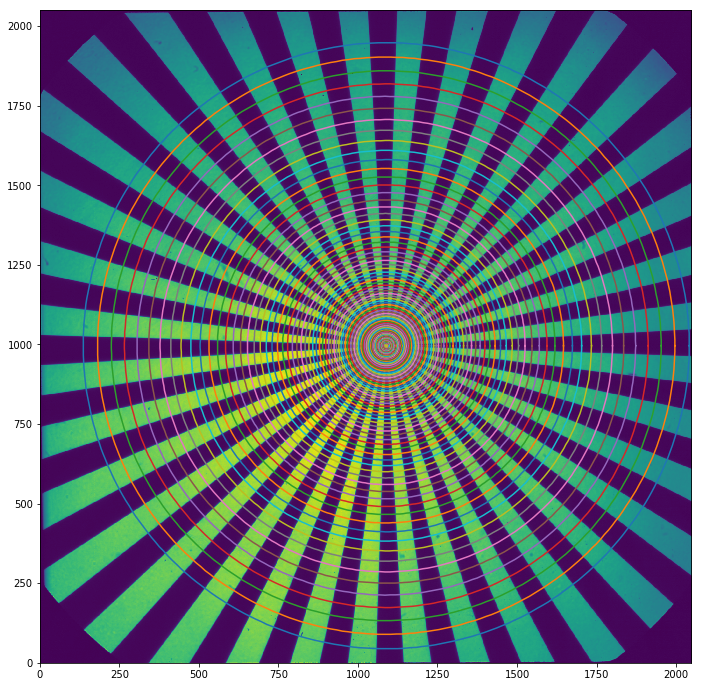

In [20]:
plt.figure(figsize=(18,12))
plt.imshow(data, origin='lower')
for r in radii:
    
    freq = get_freq(r)
    I,x,y = get_line(data,theta,r,x_c,y_c)
    plt.plot(x,y)
    

### Now we will extract the profiles along each circle, and compute the contrast modulation.
### For computing the contrast modulation, we have to pay attention to the type of profiles. Our target will return square profiles instead of sinusoidal. So fitting the profile with a sinusoidal function is not going to return the right contrast. Let's show why. Let us extract the profile at one radius and fit it with a sinusoidal function.

In [22]:
def sinusoidal(theta,a,b,c):
    N_p = 36
    y = a + b*np.sin(N_p*theta) + c*np.cos(N_p*theta) 
    return y

def fit_sinusoid(I,theta,p0):
    popt, pcov = curve_fit(sinusoidal,theta,I,p0)
    a = popt[0]
    b = popt[1]
    c = popt[2]
    modulation = np.sqrt(b**2 + c**2)/a
    return modulation, popt


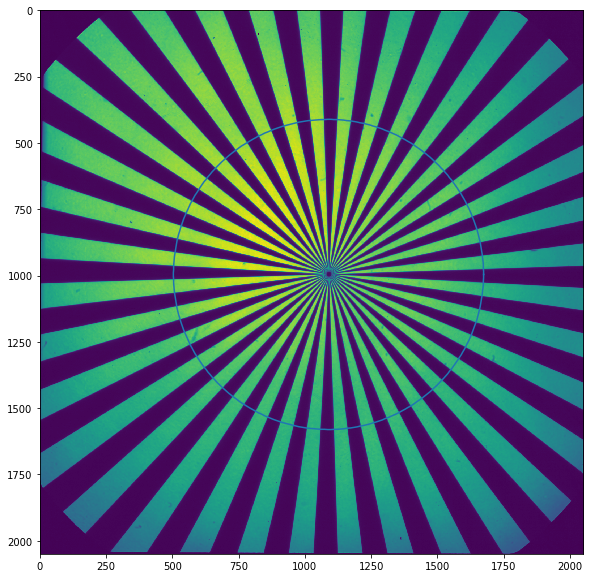

In [24]:
r = radii[10]

I,x,y = get_line(data,theta,r,x_c,y_c)
p0 = [(I.max()-I.min())/2, (I.max() -(I.max()-I.min())/2)/5, -(I.max()-I.min())/2 ]
m,popt = fit_sinusoid(I,theta,p0)

plt.figure(figsize=(18,10)) 
plt.imshow(data)
ax = plt.gca() 
ax.set_aspect(1) 
plt.plot(x,y)

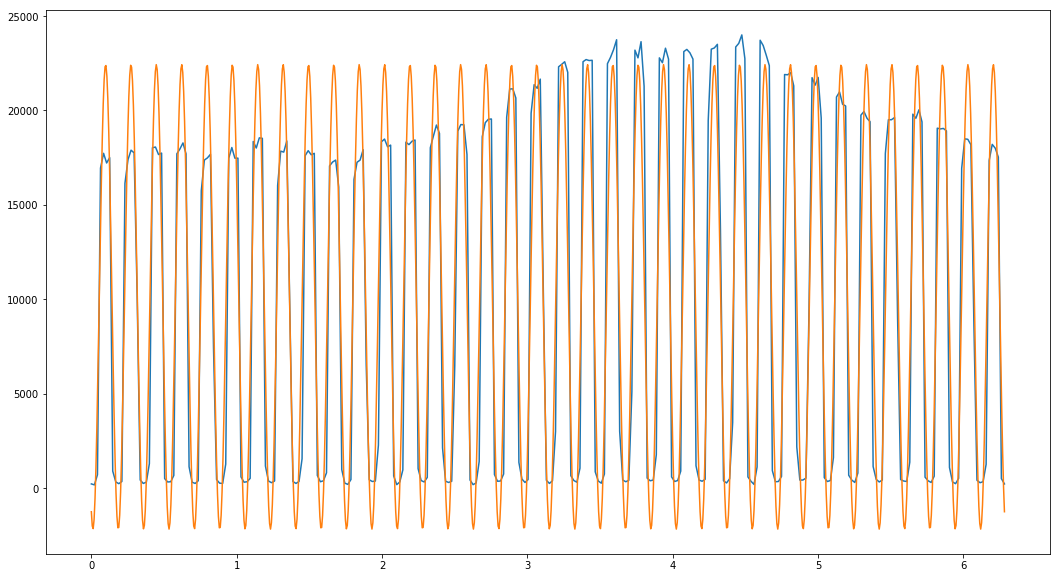

In [27]:
plt.figure(figsize=(18,10))
plt.plot(theta,I)
xnew = np.linspace(0,theta.max(),1000)
ynew = sinusoidal(xnew,*popt)
plt.plot(xnew,ynew)

### you can see why the sinusoidal fit will definitely return wrong values of the modulation since it overestimates it. Also it will miss the high frequency contribution you get from the square profiles.

### So instead of the sinusoidal fit, I will locate the maxima and minima and average them, then use this equation:
$
\begin{equation}
M = \frac{I_{max} - I_{min}}{I_{max} + I_{min}}
\end{equation}
$
### With I_max the average of the maximum values and I_min the average of the minimum values. For this to work I use the <a href='https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.argrelextrema.html' >scipy.signal.argrelextrema</a> function to locate the extrema of the smoothed profile. 

In [34]:
import scipy
from scipy import signal
from scipy.signal import argrelextrema
from scipy.signal import savgol_filter


In [36]:
lines = np.zeros((N_radii,2))
n=0
for r in radii:
    
    freq = N_p/(2*np.pi*r)
    I,x,y = get_line(data,theta,r,x_c,y_c)
    
    if freq<0.45:
        yhat = savgol_filter(I, 11, 2)
    elif freq>=0.45:
        yhat = savgol_filter(I, 15, 2) 

    maximums = scipy.signal.argrelextrema(yhat, np.greater,order=2)
    minimums = scipy.signal.argrelextrema(yhat, np.less,order=2)
        
   
    m = (I[maximums].mean() - I[minimums].mean())/(I[maximums].mean() + I[minimums].mean())
   
    lines[n][0] = freq; lines[n][1] = m
      
   
    n=n+1



### Now let us plot the profile along with its gaussian fit and with what the theory expects from the MTF given our optical system resolution.

In [38]:
def Gaussian(x,a,x0,sigma):
  y = a*(1/(np.sqrt(2*np.pi)*sigma))*np.exp(-(x-x0)**2/(2*sigma**2))
  #y = np.exp(-2*(np.pi**2)*((x-x0)**2)*sigma**2)
  return y

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


(0, 0.7)

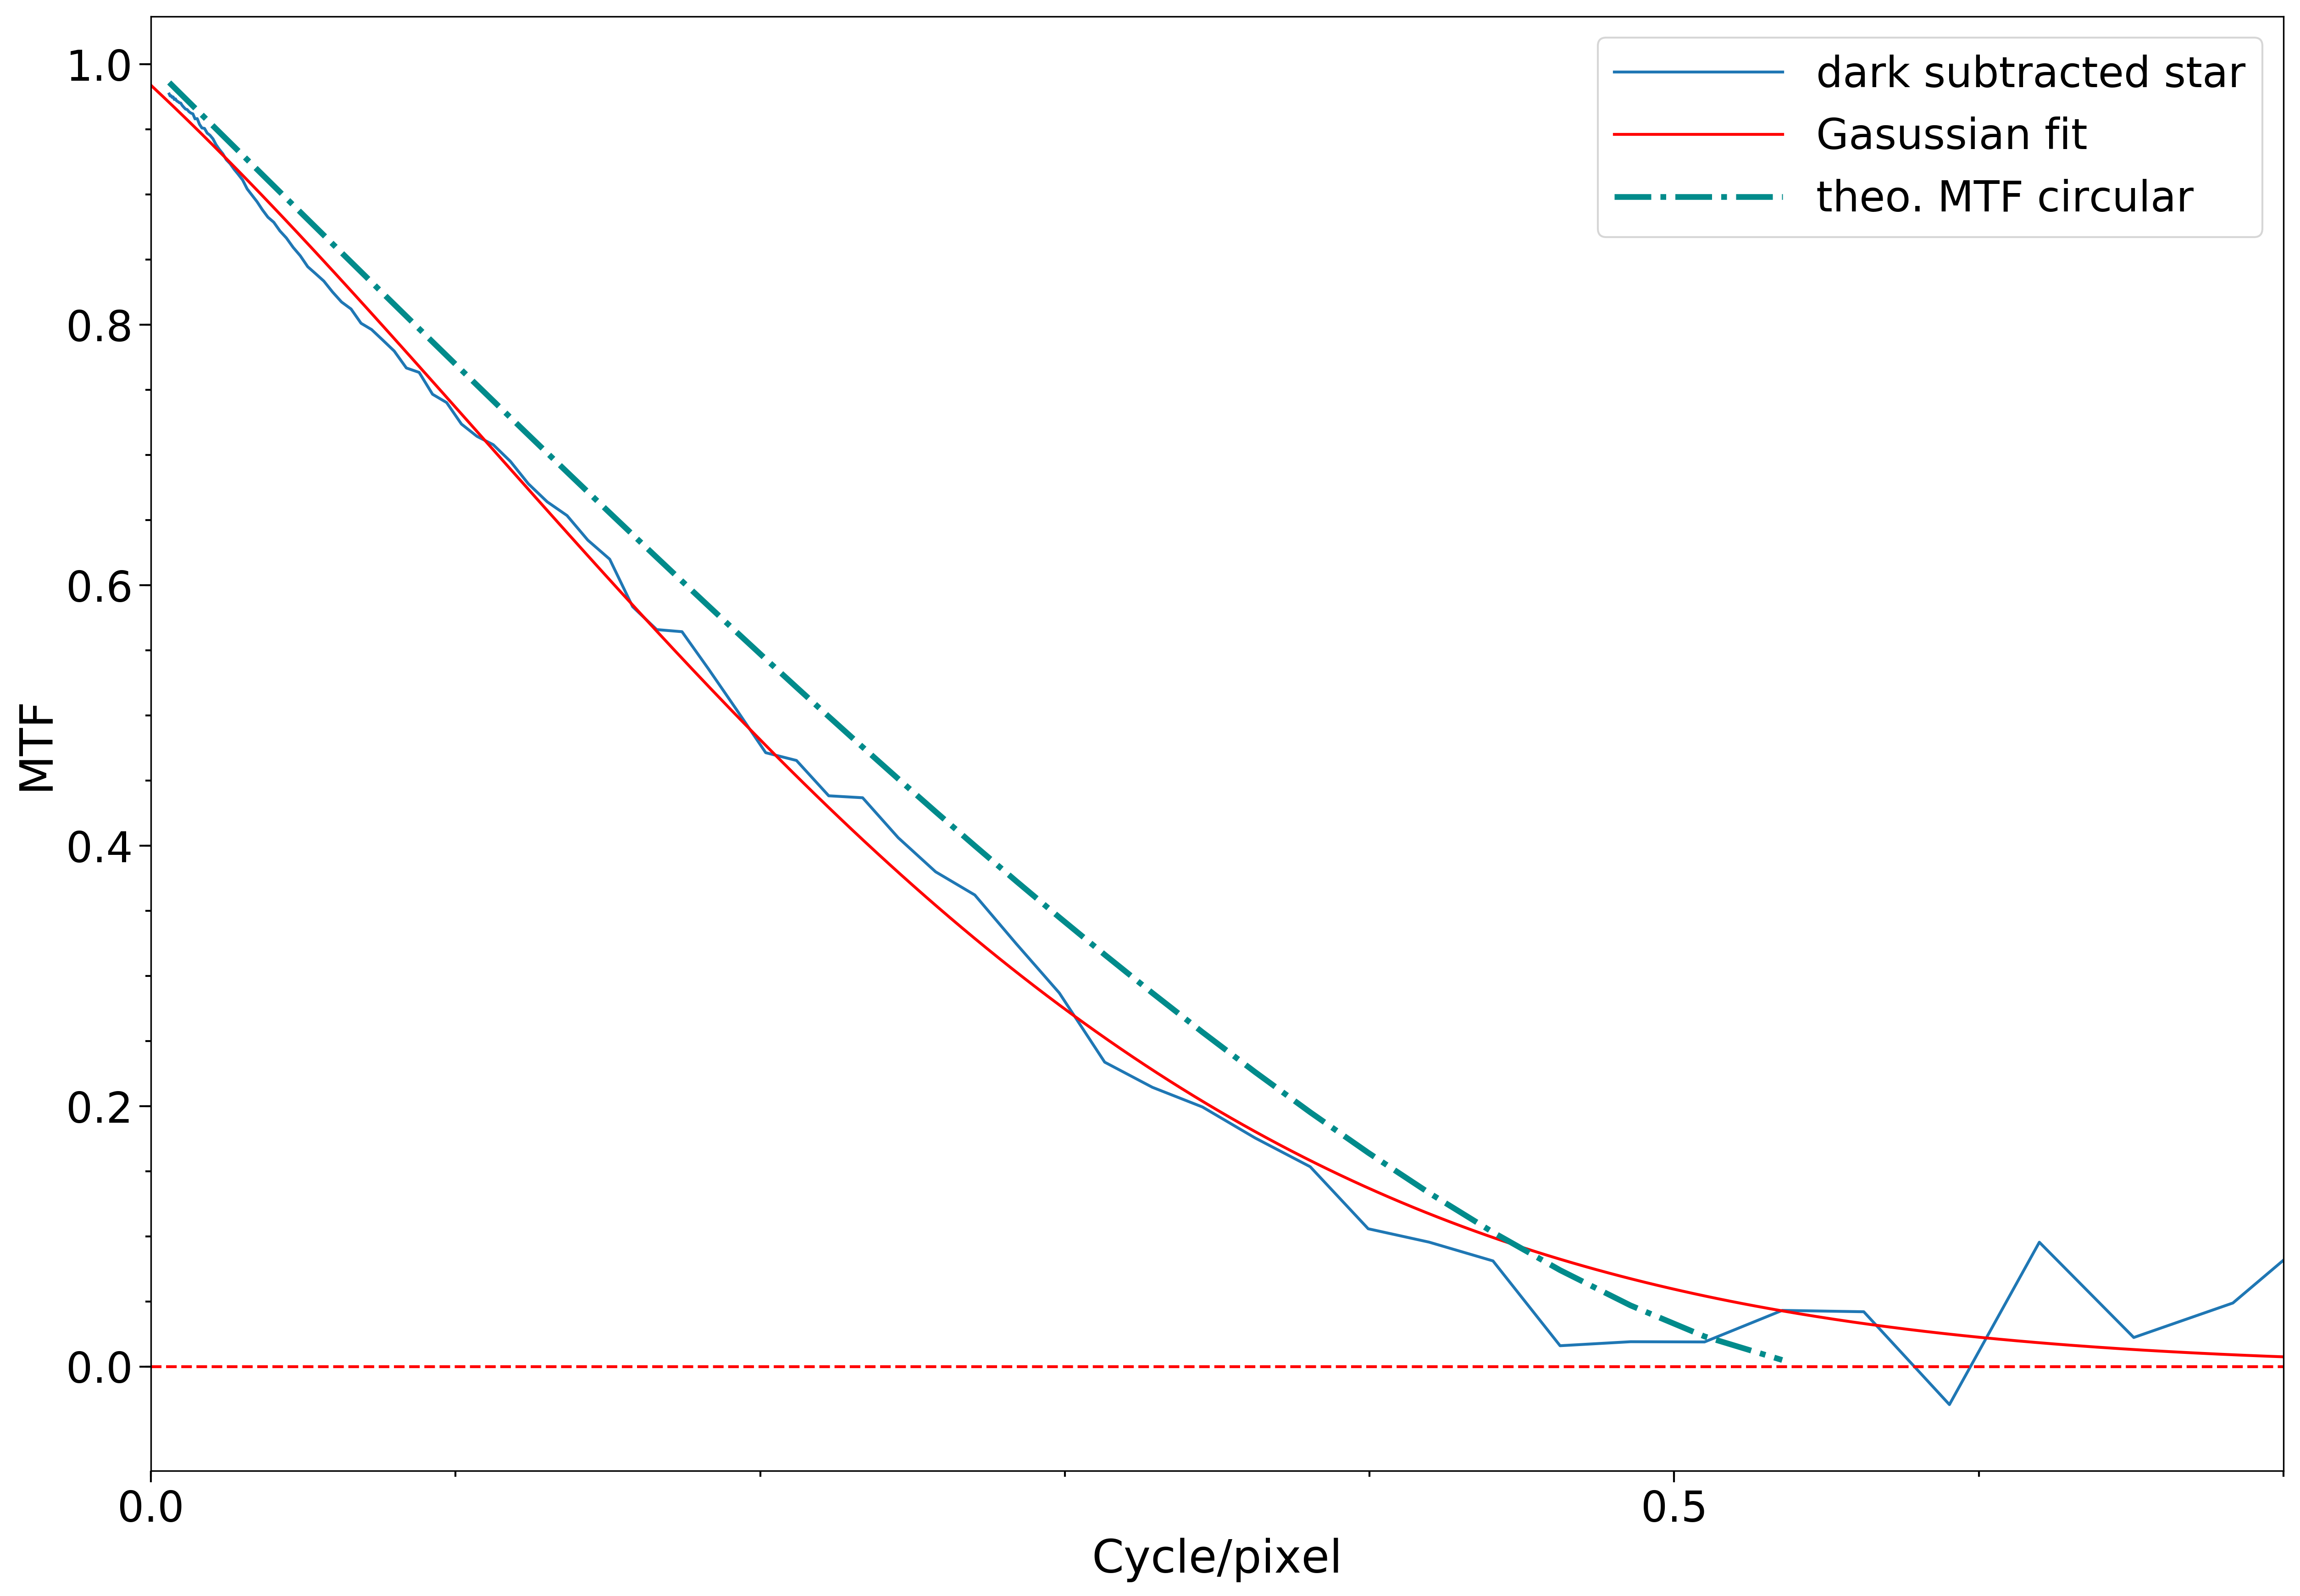

In [40]:
plt.clf()
figure=plt.figure(figsize=(20,14),dpi=300)
ax = figure.add_subplot(111)
ax.set_xlabel('Cycle/pixel',fontsize=24)
ax.set_ylabel('MTF',fontsize=24)
major_ticks = np.arange(0, 2,0.5)
minor_ticks = np.arange(0, 2, 0.1)
major_ticks_y = np.arange(0, 1.8,0.2)
minor_ticks_y = np.arange(0, 1.8, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor = True)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor = True)
ax.tick_params(axis = 'both', which = 'major', length=6, width=1,labelsize = 22)
ax.tick_params(axis = 'both', which = 'minor', length=3, width=1,labelsize=22)


freq_all = lines[:,0]
M_all = lines[:,1]

# remove last outlier point
freq_all =freq_all[:-1]#/ 0.5
M_all = M_all[:-1]
#M_all =M_all/M_all.max()

## fit MTF with a gaussian
p0_g = [1,0,0.5]
popt, pcov = curve_fit(Gaussian,freq_all[:100],M_all[:100],p0_g,maxfev=8000)
xnew = np.linspace(0,2,1000)
ynew = Gaussian(xnew,*popt)



## perfect MTF (circular aperture, no aberrations):

D = 140
lam = 617.3*10**(-6)
f = 4125.3
#in pixels
freq_c = D/(lam*f*100)
#in arcsec
#freq_c = D/(1.22*lam*206265)



phi = np.arccos(freq_all/freq_c)
MTF_p = (2/np.pi)*(phi - (np.cos(phi))*np.sin(phi))

## plot results
plt.plot(freq_all,M_all,label='dark subtracted star')

plt.plot(xnew,ynew,'r',label='Gasussian fit')
plt.axhline(y=0,linestyle='dashed',color='red')
plt.plot(freq_all,MTF_p,label='theo. MTF circular',color='darkcyan',linestyle='-.',linewidth=3)

ax.legend(loc='best',fancybox=True, handlelength=4,fontsize=22)
ax.set_xlim(0,0.7)



### You can see that our profile is not so far from the theoretical profile, which tells us that our optical system is almost diffraction limited!

# La fin!